In [2]:
# Tarvittavien kirjastojen tuonti
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


2024-03-24 21:23:02.174859: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-24 21:23:02.175534: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-24 21:23:02.179727: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-24 21:23:02.229411: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 21:23:03.175223: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [4]:
import glob
# Oletetaan, että sinulla on lista kappalepolkuja ja vastaavia tanssilajilabeleita
# Kansion nimi vastaa labelia (esim. salsa, tango, ...) 
kappalepolut = glob.glob(f'{KOULUTUS_DATA_POLKU}/*/*.mp3')
tanssilajilabelit = [polku.split('/')[-2] for polku in kappalepolut]
    
#Pilkotaan jokainen kappaletiedosto 10 sekunnin pituisiin pätkiin

def pilko_kappaleet(kappalepolut, tanssilajilabelit, pituus=NÄYTTEEN_PITUUS):
    X = []
    y = []
    for polku, label in zip(kappalepolut, tanssilajilabelit):
        kappale, sr = librosa.load(polku, offset=KAPPALEEN_ALKU_OFFSET)
        for i in range(0, len(kappale) - sr*pituus, sr*pituus):
            X.append(kappale[i:i+sr*pituus])
            y.append(label)
    return np.array(X), np.array(y)

näytteet, näytteiden_labelit = pilko_kappaleet(kappalepolut, tanssilajilabelit)

#Tarkistetaan, että data on pilkottu oikein
print(näytteet.shape)
print(näytteiden_labelit.shape)


(1734, 220500)
(1734,)


Muunnetaan kappaleet spektogrammeiksi

In [5]:
N_FFT = 512
HOP_LENGTH = N_FFT // 2
N_MELS = 64 

def luo_spektrogrammi(aaltomuoto):
    melspec = librosa.feature.melspectrogram(y=aaltomuoto, hop_length = HOP_LENGTH, n_fft = N_FFT, n_mels = N_MELS)
    melspec = librosa.power_to_db(melspec**2)
    return melspec
   

# Ladataan ja esikäsitellään data
spektrogrammit = np.array([luo_spektrogrammi(näyte) for näyte in näytteet])

['fusku' 'salsa' 'valssi']


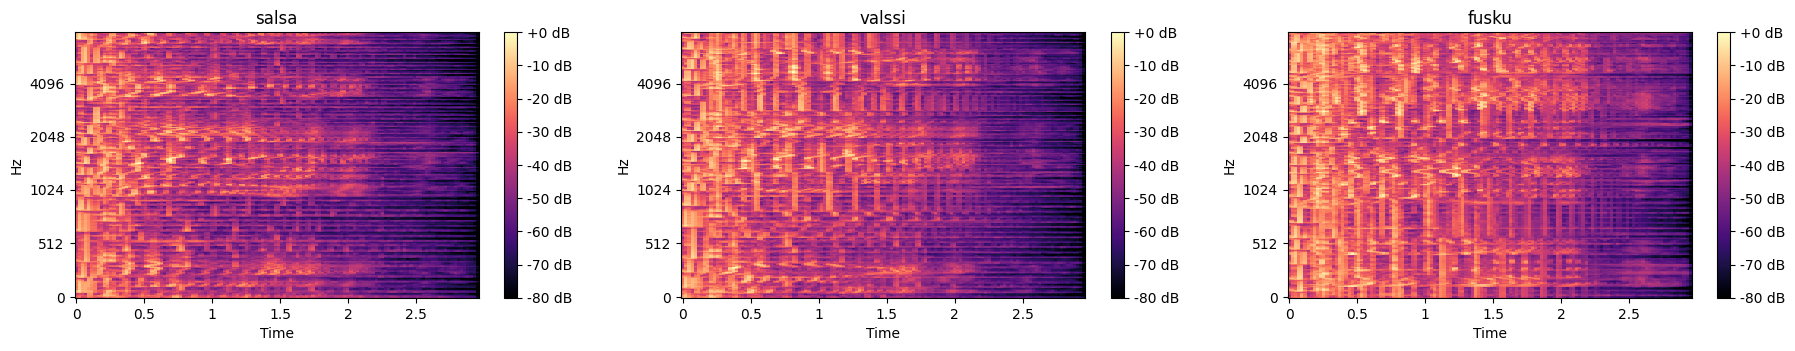

In [42]:
#tulosta kaikki eri labelit
print(np.unique(näytteiden_labelit))

#index missä labelit vaihtuvat
indexes = np.where(näytteiden_labelit[:-1] != näytteiden_labelit[1:])[0] + 1
#add 0 to the beginning
indexes = np.insert(indexes, 0, 0)

#plot one of each dance style using idexes
plt.figure(figsize=(30, 20))

for i, index in enumerate(indexes):
    plt.subplot(5, 4, i+1)
    librosa.display.specshow(spektrogrammit[i], y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(näytteiden_labelit[index])

In [6]:

#Muutetaan numpy arrayksi
spektrogrammit = np.array(spektrogrammit)

# Labelien käsittely
label_encoder = LabelEncoder()
tanssilaji_numerot = label_encoder.fit_transform(näytteiden_labelit)
tanssilaji_one_hot = to_categorical(tanssilaji_numerot)

# Jaa data opetus- ja testisetteihin
X_train, X_test, y_train, y_test = train_test_split(spektrogrammit, tanssilaji_one_hot, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(1387, 64, 862)
(347, 64, 862)
(1387, 3)
(347, 3)


In [2]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K


# metriikka mallin arvioimiseksi
def metric(y_true, y_pred):
    return K.mean(K.equal(K.argmax(y_true, axis=1), K.argmax(y_pred, axis=1)))

# CNN-mallin määrittely
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2], 1)),
    Conv2D(64, kernel_size=(4, 4), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 4)),
    Conv2D(64, (3, 5), activation='relu'
                    , kernel_regularizer=regularizers.l2(0.04)
                    ),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Conv2D(64, (2, 2), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.04)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.04)),
    Dense(y_train.shape[1], activation='softmax')
])

# Mallin kokoaminen
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[metric])

2024-04-03 14:16:23.315484: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-03 14:16:23.316920: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-03 14:16:23.373781: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-03 14:16:23.576450: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 14:16:24.356046: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

NameError: name 'X_train' is not defined

In [1]:
#visualize the model
model.summary()

NameError: name 'model' is not defined

In [12]:
# Mallin kouluttaminen
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step - loss: 10.0399 - metric: 0.4103 - val_loss: 6.3139 - val_metric: 0.4870
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 163s 4s/step - loss: 5.5506 - metric: 0.4796 - val_loss: 4.2960 - val_metric: 0.4870
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 164s 4s/step - loss: 3.2956 - metric: 0.5189 - val_loss: 2.4123 - val_metric: 0.6526
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 198s 4s/step - loss: 2.2457 - metric: 0.6500 - val_loss: 1.6124 - val_metric: 0.8473
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 165s 4s/step - loss: 1.9266 - metric: 0.7025 - val_loss: 1.5843 - val_metric: 0.7742
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 164s 4s/step - loss: 1.4945 - metric: 0.7586 - val_loss: 1.1511 - val_metric: 0.8814
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 163s 4s/step - loss: 1.2086 - metric: 0.7891 - val_loss: 1.1677 - val_metric: 0.8468
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 166s 4s/step - loss: 1.1572 - metric: 0.8033 - val_loss: 1.0160 - val_metric: 0.8905
Epoch 9/10
44/4

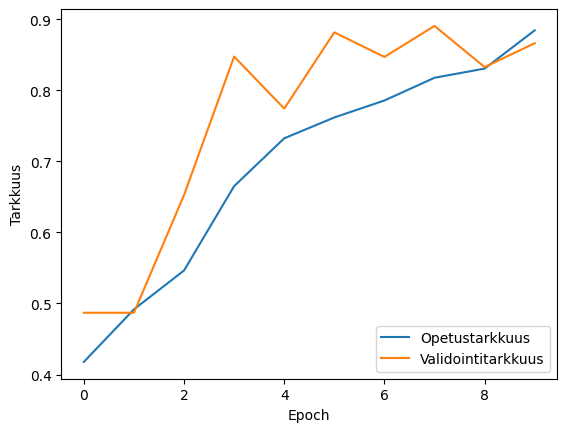

In [14]:
# Mallin suorituskyvyn evaluointi
plt.plot(history.history['metric'], label='Opetustarkkuus')
plt.plot(history.history['val_metric'], label='Validointitarkkuus')
plt.xlabel('Epoch')
plt.ylabel('Tarkkuus')
plt.legend()
plt.show()

In [15]:

#load validation data from validation folder
validation_files = glob.glob(f'{VALIDOINTI_DATA_POLKU}/*/*.mp3')
validation_labels = [polku.split('/')[-2] for polku in validation_files]


def lataa_ja_muunna_audio(audio_tiedosto):
    aaltomuoto, sr = librosa.load(audio_tiedosto, offset=KAPPALEEN_ALKU_OFFSET, duration=NÄYTTEEN_PITUUS)
    return aaltomuoto, sr

validation_spectrograms = []

for polku in validation_files:
    aaltomuoto, sr = lataa_ja_muunna_audio(polku)
    spektrogrammi = luo_spektrogrammi(aaltomuoto)
    validation_spectrograms.append(spektrogrammi)

validation_spectrograms_np = np.array(validation_spectrograms)
validation_labels_numerical = label_encoder.transform(validation_labels)
validation_labels_one_hot = to_categorical(validation_labels_numerical)

print(validation_spectrograms_np.shape)

(99, 64, 862)


4/4 - 1s - 207ms/step - loss: 0.9143 - metric: 0.8906
Malli saavutti validoinnissa 89.06% tarkkuuden
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step
True Real: salsa, Predicted: salsa, Confidence: 1.00 Song name: Tu Cariñito
True Real: salsa, Predicted: salsa, Confidence: 0.94 Song name: Fabricando Fantasias - Salsa Version
True Real: salsa, Predicted: salsa, Confidence: 0.99 Song name: Amores como el nuestro (Salsa)
True Real: salsa, Predicted: salsa, Confidence: 0.96 Song name: Mi Gente
True Real: salsa, Predicted: salsa, Confidence: 0.79 Song name: Cali Pachanguero
True Real: salsa, Predicted: salsa, Confidence: 0.99 Song name: Que Locura Enamorarme De Ti
True Real: salsa, Predicted: salsa, Confidence: 0.75 Song name: Amiga
True Real: salsa, Predicted: salsa, Confidence: 0.97 Song name: Valió la Pena - Salsa Version
True Real: salsa, Predicted: salsa, Confidence: 0.90 Song name: Eres Mi Sueño - Salsa
True Real: salsa, Predicted: salsa, Confidence: 0.92 Song name: Será Que Si
True Real: salsa

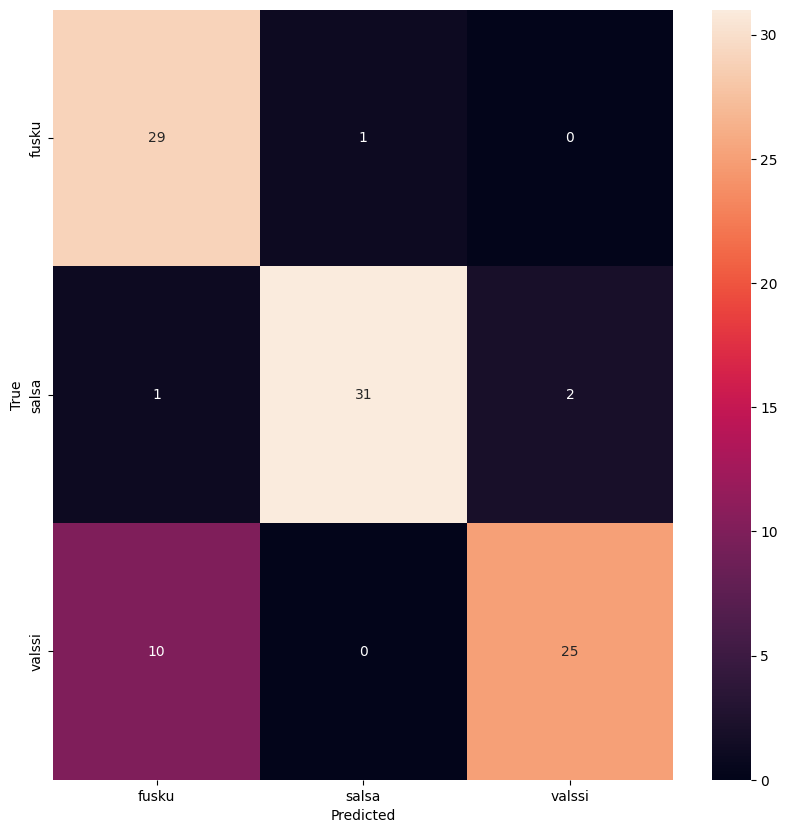

In [22]:


#evaluate the model on the validation data
#use labels to convert one-hot encoded test labels to their original format
test_loss, test_acc = model.evaluate(validation_spectrograms_np, validation_labels_one_hot, verbose=2)
print(f'Malli saavutti validoinnissa {test_acc*100:.2f}% tarkkuuden')

#predict the labels for the validation data
predicted_labels_one_hot = model.predict(validation_spectrograms_np)
predicted_labels = label_encoder.inverse_transform(np.argmax(predicted_labels_one_hot, axis=1))
true_labels = np.array(validation_labels)

# Get the confidence (probability) of the predicted class
predicted_confidence = np.max(predicted_labels_one_hot, axis=1)

# Print the true and predicted labels for the first 10 examples
for i in range(len(validation_files)):
    prediction_true = true_labels[i] == predicted_labels[i]
    print(f'{prediction_true} Real: {true_labels[i]}, Predicted: {predicted_labels[i]}, Confidence: {predicted_confidence[i]:.2f} Song name: {validation_files[i].split("/")[-1].split(".")[0]}')

#plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_labels, labels=label_encoder.classes_)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [18]:
# save the model whit the best accuracy
model.save('tanssimallimme.keras')
print('Malli tallennettu tiedostoon tanssimallimme.keras')

Malli tallennettu tiedostoon tanssimallimme.h5
